# 1.3「転移学習」で少量データの分類を実現する方法

- 本ファイルでは、学習済みのVGGモデルを使用し、転移学習でアリとハチの画像を分類するモデルを学習します


# 学習目標

1. 画像データからDatasetを作成できるようになる
2. DataSetからDataLoaderを作成できるようになる
3. 学習済みモデルの出力層を任意の形に変更できるようになる
4. 出力層の結合パラメータのみを学習させ、転移学習が実装できるようになる



# 事前準備

1. 書籍の指示に従い、本章で使用するデータをダウンロード

2. forループの経過時間と残り時間を計測するパッケージtqdmをインストールします。

conda install -c conda-forge tqdm



In [1]:
# パッケージのimport
import glob # ファイルパスを検索
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm # 進捗バー
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data #Dataloaderなど
import torchvision # 画像処理関連
from torchvision import models, transforms # 事前学習済みモデル(VGG, ResNet, AlexNetなど), 画像の前処理(リサイズ、正規化など)


In [2]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# DataSetを作成

3ステップ
- 前処理クラスImageTransform
- ファイルパスをリスト型変数に格納するmake_datapath_list
- これらを利用したHymenopteraDataset

ImageTransform
- RandomResizedCropとRandomHorizontalFLip
- データオーグメンテーション（水増し）を行う

In [3]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # スケーリング的な何か
                transforms.RandomHorizontalFlip(),  # 50%の確率で反転
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)


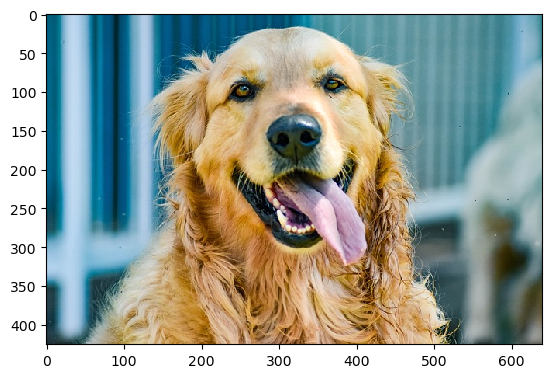

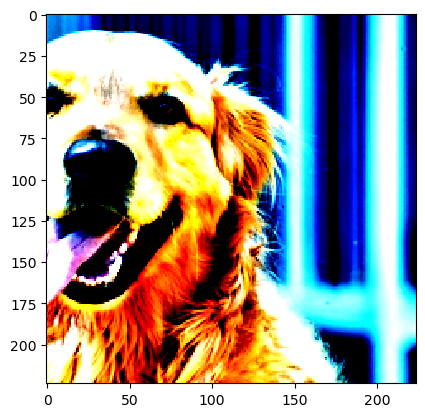

In [4]:
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる

# 1. 画像読み込み
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)   # [高さ][幅][色RGB]

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()


アリとハチの訓練データの画像は合計243枚、検証データは153枚
- osp.joinでファイルパスの文字列作成
- globでファイルパスを取得

In [5]:
# アリとハチの画像へのファイルパスのリストを作成する


def make_datapath_list(phase="train"):
    """
    データのパスを格納したリストを作成する。

    Parameters
    ----------
    phase : 'train' or 'val'
        訓練データか検証データかを指定する

    Returns
    -------
    path_list : list
        データへのパスを格納したリスト
    """

    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    # **はワイルドカードの一種でサブディレクトリも含めて全てのファイルパスを検索
    print(target_path)#./data/hymenoptera_data/train/ants/001.jpgなど

    path_list = []  # ここに格納する

    # globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path): 
        #glob.glob関数は、指定したパスパターンに一致するファイルやディレクトリを検索し、それらのパスをリストとして返す
        path_list.append(path)

    return path_list


# 実行
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list


./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train/bees/452462677_7be43af8ff.jpg',
 './data/hymenoptera_data/train/bees/2580598377_a4caecdb54.jpg',
 './data/hymenoptera_data/train/bees/150013791_969d9a968b.jpg',
 './data/hymenoptera_data/train/bees/3079610310_ac2d0ae7bc.jpg',
 './data/hymenoptera_data/train/bees/2528444139_fa728b0f5b.jpg',
 './data/hymenoptera_data/train/bees/2792000093_e8ae0718cf.jpg',
 './data/hymenoptera_data/train/bees/2445215254_51698ff797.jpg',
 './data/hymenoptera_data/train/bees/174142798_e5ad6d76e0.jpg',
 './data/hymenoptera_data/train/bees/2031225713_50ed499635.jpg',
 './data/hymenoptera_data/train/bees/2452236943_255bfd9e58.jpg',
 './data/hymenoptera_data/train/bees/2551813042_8a070aeb2b.jpg',
 './data/hymenoptera_data/train/bees/1508176360_2972117c9d.jpg',
 './data/hymenoptera_data/train/bees/2477324698_3d4b1b1cab.jpg',
 './data/hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg',
 './data/hymenoptera_data/train/bees/1807583459_4fe92b3133.jpg',
 './data/hymenoptera_data/tr

## Datasetのクラスを作成
- 訓練データと検証データのインスタンスを作成
- 画像読み込み時に前処理クラスImageTransformを適応
- アリのlabelを0、ハチのlabelを1とする

pytorchのDatasetクラスを継承するときには以下が必要
- __getitem()はデータを1つ取り出すメソッド
-  __len __()はファイル数を返すメソッド

In [6]:
# アリとハチの画像のDatasetを作成する


class HymenopteraDataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベルをファイル名から抜き出す
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]

        # ラベルを数値に変更する
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1

        return img_transformed, label   # テンソルとラベルを返す


# 実行
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')
# train_listは上で作ったファイルパスのリスト

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 0
# __getitem__はテンソルとラベルを返す
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 224, 224])
1


In [7]:
train_dataset.__len__()

243

In [8]:
val_dataset.__len__()

153

# DataLoaderを作成

- Pytorchのtorch.utils.data.DataLoaderクラスをそのまま使用
- 訓練中はshuffle=Trueでランダムに画像を取り出す
- 訓練用と検証用のDataLoaderを作成して辞書型変数dataloaders_dictに格納

- イテレータとは要素を順に1つずつ取り出すためのオブジェクト
- next()関数を使うことで次の要素を取得できる

In [9]:
# ミニバッチのサイズを指定
batch_size = 32

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())    # tensor
print(labels)   # label


torch.Size([32, 3, 224, 224])
tensor([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1])


# ネットワークモデルの作成する

VGG16をロード
- 出力ユニット数が1000では無く、2になるので最後の全結合層を付け替える
- net.classfire[6]=nn.Linear(in_features=4096, out_features=2)

In [10]:
# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)

# VGG16の最後の出力層の出力ユニットをアリとハチの2つに付け替える
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 訓練モードに設定
net.train()

print('ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました')


/home/riku/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/riku/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました


# 損失関数を定義

In [11]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# 最適化手法を設定

- requires_grad=Trueのパラメータは誤差逆伝播で勾配が計算される
- Falseならパラメータが固定されて計算されない

In [12]:
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["classifier.6.weight", "classifier.6.bias"]#VGG16の最後の全結合層の重みとバイアスだけ学習

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in net.named_parameters():
    if name in update_param_names: # 上のリストに含まれるパラメータ
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_updateの中身を確認
print("-----------")
print(params_to_update)# 学習するパラメータ。つまり重みとバイアス


classifier.6.weight
classifier.6.bias
-----------
[Parameter containing:
tensor([[-0.0050,  0.0137,  0.0001,  ..., -0.0086, -0.0043,  0.0068],
        [ 0.0154, -0.0071,  0.0155,  ..., -0.0146,  0.0047,  0.0141]],
       requires_grad=True), Parameter containing:
tensor([-0.0041,  0.0061], requires_grad=True)]


In [13]:
# 最適化手法の設定
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)#先程のparams_to_updateを引数に指定


# 学習・検証を実施

- train_model関数を定義
- train_model関数は学習と検証をepochごとに交互に実施
- with torch.set_grad_enabled(phase=="train"):は学習時のみ勾配を計算させる設定
- loss.item()*input.size(0)によりミニバッチの合計損失を計算

In [14]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


In [15]:
# 学習・検証を実行する
num_epochs=3
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/3
-------------


100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


val Loss: 0.6532 Acc: 0.6471
Epoch 2/3
-------------


100%|██████████| 8/8 [00:16<00:00,  2.02s/it]


train Loss: 0.4770 Acc: 0.7449


100%|██████████| 5/5 [00:10<00:00,  2.04s/it]


val Loss: 0.1885 Acc: 0.9412
Epoch 3/3
-------------


100%|██████████| 8/8 [00:16<00:00,  2.01s/it]


train Loss: 0.1364 Acc: 0.9424


100%|██████████| 5/5 [00:10<00:00,  2.07s/it]

val Loss: 0.1293 Acc: 0.9477


以上

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


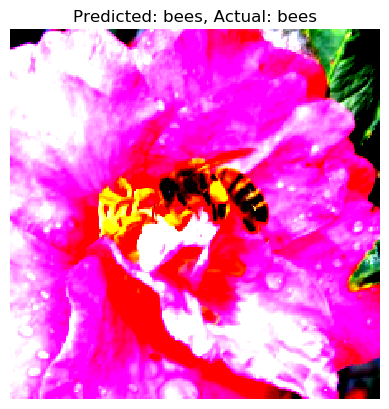

In [26]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image

# サンプルデータの取得と表示
sample_index = 5  # 任意のサンプルを使用
test_image, test_label = val_dataset[sample_index]  # 検証データセットから取得

# モデルを評価モードに設定
net.eval()

# ミニバッチの次元を追加 (モデルの入力に合わせるため)
test_image = test_image.unsqueeze(0)  # torch.Size([3, 224, 224]) -> torch.Size([1, 3, 224, 224])

# 推論の実行
with torch.no_grad():
    outputs = net(test_image)
    _, predicted = torch.max(outputs, 1)

# 予測結果の表示
classes = ['ants', 'bees']

# サンプル画像の表示
# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
test_image_np = test_image.squeeze(0).numpy().transpose((1, 2, 0))
test_image_np = np.clip(test_image_np, 0, 1)# imshow関数が受け付ける範囲に整形
plt.imshow(test_image_np)
plt.title(f'Predicted: {classes[predicted[0]]}, Actual: {classes[test_label]}')
plt.axis('off')
plt.show()